# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import os

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
df_X = pd.read_csv("../data/raw/train_values.csv")
df_y = pd.read_csv("../data/raw/train_labels.csv")
df_raw = df_X.merge(df_y, on='building_id')  # Training features and labels. Will be split for validation.
df_raw_test = pd.read_csv("../data/raw/test_values.csv")  # Test features, NO labels (used for submission)

In [3]:
# Repo root directory is the parent of the current directory (notebooks)
!pwd

/home/devin/git/data-driven-nepal-earthquake/notebooks


In [4]:
# Script variables
dir_root = os.path.dirname(os.getcwd())
dir_data = os.path.join(dir_root, 'data/')
dir_data_raw = os.path.join(dir_data, 'raw/')
dir_data_interim = os.path.join(dir_data, 'interim/')

In [5]:
!ls ../data/

download_data.sh  interim  raw	splits


# Load Train-Validation Set

In [6]:
i = 0
train_index = np.loadtxt('../data/splits/train_{}.text.gz'.format(i))
val_index = np.loadtxt('../data/splits/valid_{}.text.gz'.format(i))

df_raw_train = df_raw.loc[train_index]
df_raw_val = df_raw.loc[val_index]

(208480, 40)
(52121, 40)
(86868, 39)


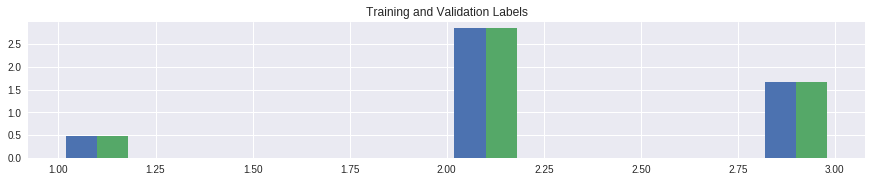

In [7]:
print(df_raw_train.shape)
print(df_raw_val.shape)
print(df_raw_test.shape)

plt.figure(figsize=(15, 2.5))
plt.hist([df_raw_train['damage_grade'].values, df_raw_val['damage_grade'].values], density=True)
plt.title("Training and Validation Labels")
plt.show()

# Feature Engineering

In [8]:
df_interim_train = df_raw_train
df_interim_val = df_raw_val
df_interim_test = df_raw_test

# Categorical object feats
cat_feats = df_raw.select_dtypes(exclude='number').columns
display(df_raw[cat_feats].nunique())

# Categorical geo feats
geo_level_id_feats = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
legal_ownership_status     4
dtype: int64

In [9]:
# Create ratio features
def create_interaction_features(df):
    return (df.assign(
        age_mul_area=df.age * df.area_percentage,
        age_div_area=df.age / df.area_percentage.replace(0, 0.1),
        age_mul_fam=df.age * df.count_families,
        age_div_fam=df.age / df.count_families.replace(0, 0.1),
        area_mul_fam=df.area_percentage * df.count_families,
        area_div_fam=df.area_percentage / df.count_families.replace(0, 0.1)
    ))

df_interim_train = create_interaction_features(df_interim_train)
df_interim_val = create_interaction_features(df_interim_val)
df_interim_test = create_interaction_features(df_interim_test)

In [10]:
# Categorical: one hot encoding
df_interim_train = pd.concat([df_interim_train, pd.get_dummies(df_interim_train[cat_feats])], axis=1)
df_interim_val = pd.concat([df_interim_val, pd.get_dummies(df_interim_val[cat_feats])], axis=1)
df_interim_test = pd.concat([df_interim_test, pd.get_dummies(df_interim_test[cat_feats])], axis=1)

In [11]:
# Define features to label encode
feats_to_label_encode = (
    list(cat_feats) + 
    geo_level_id_feats + 
    ['age', 'area_percentage', 'height_percentage', 'count_families'] +        
    ['age_mul_area', 'age_div_area', 'age_mul_fam', 'age_div_fam', 'area_mul_fam', 'area_div_fam']
)

In [12]:
feats_to_label_encode

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status',
 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'age_mul_area',
 'age_div_area',
 'age_mul_fam',
 'age_div_fam',
 'area_mul_fam',
 'area_div_fam']

In [13]:
interaction_features = ['age_mul_area', 'age_div_area', 'age_mul_fam', 'age_div_fam', 'area_mul_fam', 'area_div_fam']
bucket_features = interaction_features + ['area_percentage', 'height_percentage', 'age']

In [14]:
# Categorical: SMOOTHED mean label encoding
def calc_smooth_stat(df, by, on, stat, m=1):
    '''
    Implementation adapted from:
    https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
    
    df:   dataframe
    by:   variable to group by, eg 'geo_level_3_id'
          -OR- bins given by the the output of pd.qcut()
    on:   variable to act on eg 'geo_level_3_id'
    stat: a string naming a statistic, eg. 'mean'
    m:    the smoothing hyperparameter. The larger m is, the more we weight
          the overall statistic. The smaller m is, the more we weight the
          statistic for the given feature value.
    '''
    # Compute the global statistic
    global_stat = df[on].agg(stat)

    # Compute the number of values and the statistic of each group
    agg = df.groupby(by)[on].agg(['count', stat])
    counts = agg['count']
    # Use fillna In case count is 1 and therefore sample std is NaN.
    stats = agg[stat].fillna(global_stat)

    # Compute the "smoothed" statistics
    smooth = (counts * stats + m * global_stat) / (counts + m)

    # Replace each value by the according smoothed mean
    return smooth, global_stat

target = 'damage_grade'
for feat in feats_to_label_encode:
    if feat in bucket_features:
        by = pd.qcut(df_interim_train[feat], 10, duplicates='drop')
    else:
        by = feat
    #mappings = df_interim_train.groupby(feat)['damage_grade'].agg(['mean'])
    #mappings, mean = calc_smooth_mean(df_interim_train, by, target, m)
    mappings, mean = calc_smooth_stat(df_interim_train, by, target, 'mean')
    
    df_interim_train["{}_labelEnc".format(feat)] = df_interim_train[feat].map(mappings)
    df_interim_val["{}_labelEnc".format(feat)] = df_interim_val[feat].map(mappings).fillna(mean)
    df_interim_test["{}_labelEnc".format(feat)] = df_interim_test[feat].map(mappings).fillna(mean)
    
    if ( any(
             any(
                 np.isnan(df["{}_labelEnc".format(feat)])
             )
             for df in [df_interim_train, df_interim_val, df_interim_test]
         )
       ):
        print('Nan error')

In [15]:
# Categorical: SMOOTHED standard deviation label encoding
for feat in feats_to_label_encode:
    if feat in bucket_features:
        by = pd.qcut(df_interim_train[feat], 10, duplicates='drop')
    else:
        by = feat
    #mappings = df_interim_train.groupby(feat)['damage_grade'].agg(['std'])
    #mappings, std = calc_smooth_std(df_interim_train, by, target, m)
    mappings, std = calc_smooth_stat(df_interim_train, by, target, 'std')
    
    df_interim_train["{}_labelEncStd".format(feat)] = df_interim_train[feat].map(mappings)
    df_interim_val["{}_labelEncStd".format(feat)] = df_interim_val[feat].map(mappings).fillna(std)  # In case feat (not bucketed) not in training set
    df_interim_test["{}_labelEncStd".format(feat)] = df_interim_test[feat].map(mappings).fillna(std)  # In case feat (not bucketed) not in training set
    
    if ( any(
             any(
                 np.isnan(df["{}_labelEncStd".format(feat)])
             )
             for df in [df_interim_train, df_interim_val, df_interim_test]
         )
       ):
        print('Nan error')

In [16]:
# Categorical: count_label encoding
# The count_label encoding should allow our model to determine if the
# mean_label encoding is trust-worthy.
feat = 'geo_level_3_id'
mappings = (
            df_interim_train.groupby(feat)[feat].agg(['count'])
            .to_dict()
        )
df_interim_train["{}_countEnc".format(feat)] = df_interim_train[feat].map(mappings['count'])
df_interim_val["{}_countEnc".format(feat)] = df_interim_val[feat].map(mappings['count']).fillna(1)
df_interim_test["{}_countEnc".format(feat)] = df_interim_test[feat].map(mappings['count']).fillna(1)
print(np.argwhere(np.isnan(df_interim_train['geo_level_3_id_countEnc'])))
print(np.argwhere(np.isnan(df_interim_val['geo_level_3_id_countEnc'])))
print(np.argwhere(np.isnan(df_interim_test['geo_level_3_id_countEnc'])))

[]
[]
[]


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [17]:
df_interim_train.shape

(208480, 127)

In [18]:
# Categorical: drop original columns
df_interim_train = df_interim_train.drop(list(cat_feats) + geo_level_id_feats, axis=1)
df_interim_val = df_interim_val.drop(list(cat_feats) + geo_level_id_feats, axis=1)
df_interim_test = df_interim_test.drop(list(cat_feats) + geo_level_id_feats, axis=1)
df_interim_train.shape

(208480, 116)

In [19]:
n_feats = df_interim_train.drop(['damage_grade', 'building_id'], axis=1).shape[1]
n = df_interim_train.shape[0]

print("Num features: {}".format(n_feats))
#print("Features to data ratio: {:.3}".format(n_feats / n))
print("Features to data ratio: {0:.4f}".format(n_feats / float(n)))
display(df_interim_train.head())

Num features: 114
Features to data ratio: 0.0005


,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,age_div_area,age_div_fam,age_mul_area,age_mul_fam,area_div_fam,area_mul_fam,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,land_surface_condition_labelEnc,foundation_type_labelEnc,roof_type_labelEnc,ground_floor_type_labelEnc,other_floor_type_labelEnc,position_labelEnc,plan_configuration_labelEnc,legal_ownership_status_labelEnc,geo_level_1_id_labelEnc,geo_level_2_id_labelEnc,geo_level_3_id_labelEnc,age_labelEnc,area_percentage_labelEnc,height_percentage_labelEnc,count_families_labelEnc,age_mul_area_labelEnc,age_div_area_labelEnc,age_mul_fam_labelEnc,age_div_fam_labelEnc,area_mul_fam_labelEnc,area_div_fam_labelEnc,land_surface_condition_labelEncStd,foundation_type_labelEncStd,roof_type_labelEncStd,ground_floor_type_labelEncStd,other_floor_type_labelEncStd,position_labelEncStd,plan_configuration_labelEncStd,legal_ownership_status_labelEncStd,geo_level_1_id_labelEncStd,geo_level_2_id_labelEncStd,geo_level_3_id_labelEncStd,age_labelEncStd,area_percentage_labelEncStd,height_percentage_labelEncStd,count_families_labelEncStd,age_mul_area_labelEncStd,age_div_area_labelEncStd,age_mul_fam_labelEncStd,age_div_fam_labelEncStd,area_mul_fam_labelEncStd,area_div_fam_labelEncStd,geo_level_3_id_countEnc
0.0,802906,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,5.000000,30.0,180,30,6.0,6,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.234125,2.329248,2.269369,2.308917,2.315354,2.307441,2.243769,2.244161,2.161014,2.753516,2.806808,2.34812,2.297690,2.269575,2.246628,2.289690,2.354366,2.339024,2.337344,2.298557,2.295426,0.618057,0.564759,0.587684,0.577213,0.553316,0.611931,0.608775,0.608264,0.555874,0.431399,0.393378,0.548170,0.600123,0.576036,0.604755,0.575638,0.553477,0.553004,0.551855,0.597400,0.598596,34
1.0,28830,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1.250000,10.0,80,10,8.0,8,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.285300,2.329248,2.269369,2.247988,2.315354,2.229450,2.243769,2.244161,2.484305,2.510664,2.015885,2.20277,2.259315,2.317684,2.246628,2.246574,2.175905,2.212214,2.228721,2.262316,2.258626,0.595892,0.564759,0.587684,0.592251,0.553316,0.611135,0.608775,0.608264,0.562282,0.526118,0.406871,0.619564,0.581588,0.587495,0.604755,0.608329,0.621861,0.614844,0.611697,0.578559,0.581189,14
2.0,94947,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,2.000000,10.0,50,10,5.0,5,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.234125,2.329248,2.269369,2.308917,2.295670,2.307441,2.243769,2.244161,2.562940,2.510731,2.565

In [20]:
# Save interim data
#df_interim_train.to_csv("{}train.csv".format(dir_data_interim), index=False)
#df_interim_val.to_csv("{}val.csv".format(dir_data_interim), index=False)
#df_interim_test.to_csv("{}test.csv".format(dir_data_interim), index=False)

In [21]:
#!ls -lh $dir_data_interim

# Modeling

In [22]:
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score

## Initial Fit - XGB Classifier

In [23]:
%%time
X_train_init = df_interim_train.drop(['damage_grade', 'building_id'], axis=1).values
y_train_init = df_interim_train['damage_grade'].values

clf_xgb_init = xgb.XGBClassifier(
    objective='multiclass:softmax',
    random_state=3,
    n_estimators=50,
)

clf_xgb_init.fit(
    X_train_init,
    y_train_init,
    eval_set=[(X_train_init, y_train_init)],
    verbose=False
);

CPU times: user 1min 7s, sys: 424 ms, total: 1min 7s
Wall time: 1min 7s


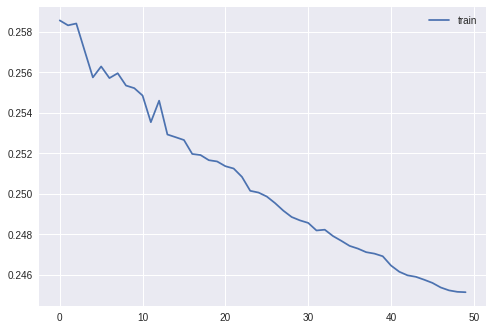

In [24]:
# Plot evaluation metrics by ntrees
plt.plot(clf_xgb_init.evals_result()['validation_0']['merror'], label='train')
plt.legend()
plt.show()

In [25]:
X_val_init = df_interim_val.drop(['damage_grade', 'building_id'], axis=1).values
y_val_init = df_interim_val['damage_grade'].values

# Predict
pred_train = clf_xgb_init.predict(X_train_init)
pred_val = clf_xgb_init.predict(X_val_init)

# Evaluate
score_train = f1_score(y_train_init.astype(int), pred_train.astype(int), average='micro')
score_val = f1_score(y_val_init.astype(int), pred_val.astype(int), average='micro')
print("Train f1 score: {}".format(score_train))
print("Val f1 score:   {}".format(score_val))

Train f1 score: 0.754873369148
Val f1 score:   0.733677404501


## Refit - XGB Classifier

In [26]:
# Get feature importances
df_feats = (
    pd.DataFrame(clf_xgb_init.feature_importances_, columns=['feature'])
    .set_index(df_interim_train.drop(['damage_grade', 'building_id'], axis=1).columns)
)

# Define good features
feats_to_keep = df_feats.reset_index()['index'].loc[(df_feats.feature != 0).values].values
print("Dropping {} features".format(np.sum(df_feats == 0)[0]))
print("Keeping  {} features".format(np.sum(df_feats != 0)[0]))

# Re-define datasets using only good features
X_train = df_interim_train.loc[:, feats_to_keep].values
X_val = df_interim_val.loc[:, feats_to_keep].values
X_test = df_interim_test.loc[:, feats_to_keep].values

y_train = df_interim_train['damage_grade'].values
y_val = df_interim_val['damage_grade'].values

Dropping 83 features
Keeping  31 features


In [27]:
%%time
def f1_eval_metric(preds, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.argmax(preds, axis=1)
    return 'f1', -1 * f1_score(y_true, y_pred, average='micro')

# Re-fit model using only good features
clf_xgb = xgb.XGBClassifier(
    objective='multiclass:softmax',
    random_state=3,
    base_score=1,
    n_estimators=150,
    learning_rate=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    gamma=0.1
)

clf_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=f1_eval_metric,
    early_stopping_rounds=10,
    verbose=False
);

CPU times: user 43.5 s, sys: 128 ms, total: 43.6 s
Wall time: 43.6 s


In [28]:
# Predict
pred_train = clf_xgb.predict(X_train)
pred_val = clf_xgb.predict(X_val)
pred_test = clf_xgb.predict(X_test)

# Evaluate
score_train = f1_score(y_train.astype(int), pred_train.astype(int), average='micro')
score_val = f1_score(y_val.astype(int), pred_val.astype(int), average='micro')
print("Train f1 score: {}".format(score_train))
print("Val f1 score:   {}".format(score_val))
# No smoothing
#   Train f1 score: 0.760576554106
#   Val f1 score:   0.734962874849
# Smoothed mean
#   Train f1 score: 0.760701266309
#   Val f1 score:   0.738589052397
# Smooted mean AND std
#   Train f1 score: 0.763905410591
#   Val f1 score:   0.739567544752

Train f1 score: 0.763905410591
Val f1 score:   0.739567544752


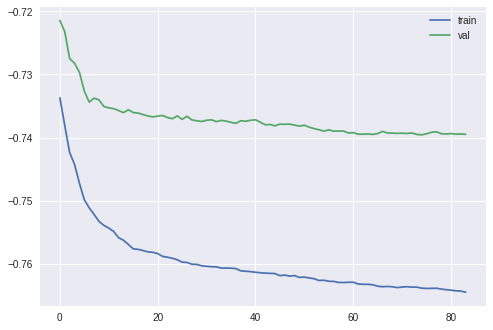

best ntree limit: 75


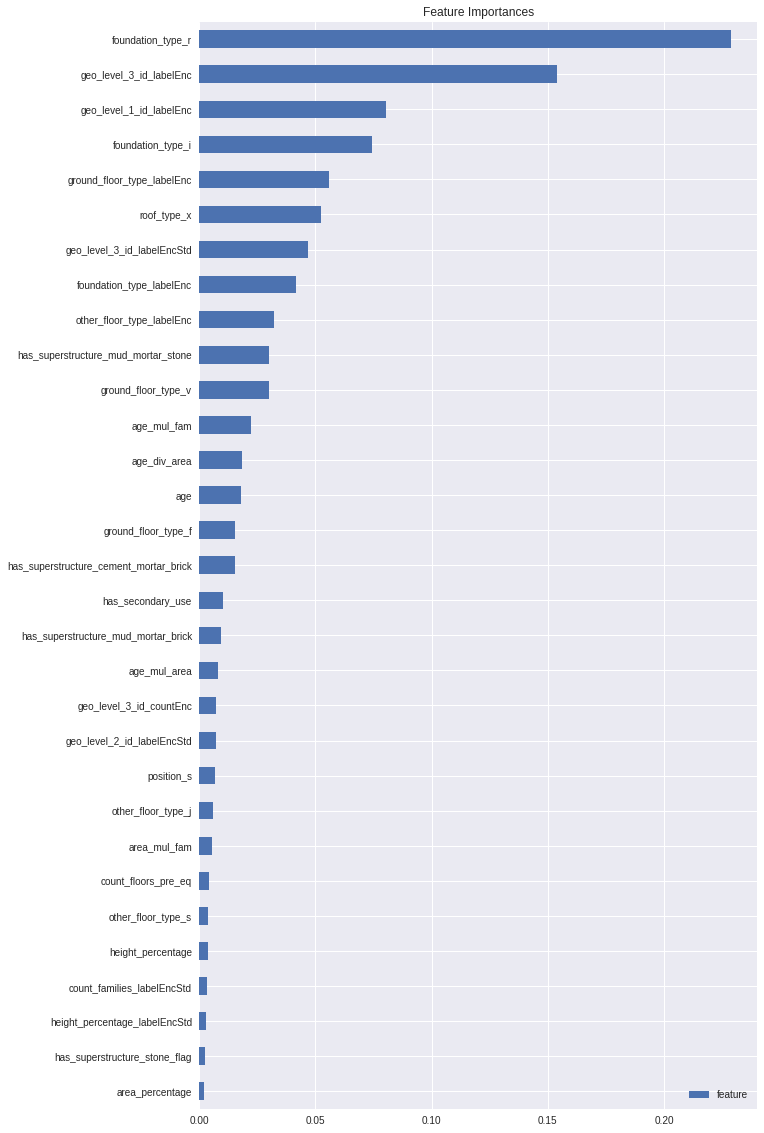

In [29]:
# Plot evaluation metrics by ntrees
plt.plot(clf_xgb.evals_result()['validation_0']['f1'], label='train')
plt.plot(clf_xgb.evals_result()['validation_1']['f1'], label='val')
plt.legend()
plt.show()
print("best ntree limit: {}".format(clf_xgb.best_ntree_limit))

# Plot feature importances
df_feats = (
    pd.DataFrame(clf_xgb.feature_importances_, columns=['feature'])
    .set_index(df_interim_train.loc[:, feats_to_keep].columns)
    .sort_values('feature')
)
df_feats.plot(kind='barh', figsize=(10, 20), title="Feature Importances")
plt.show()

## Ablation - XGB Classifier

In [30]:
# Re-define datasets using only 1 feature
single_feats_to_keep = ['geo_level_3_id_labelEnc',
                        'geo_level_2_id_labelEnc',
                        'foundation_type_i',
                        'foundation_type_r',
                        'ground_floor_type_v',
                        'roof_type_x',
                        'geo_level_3_id_labelEncStd',
                        'ground_floor_type_labelEnc',
                        'count_families',
                        'geo_level_3_id_countEnc'
                        ]
for feat in single_feats_to_keep:
    feats_to_keep = [feat]
    X_train = df_interim_train.loc[:, feats_to_keep].values
    X_val = df_interim_val.loc[:, feats_to_keep].values

    y_train = df_interim_train['damage_grade'].values
    y_val = df_interim_val['damage_grade'].values

    # Re-fit model using only good features
    clf_xgb = xgb.XGBClassifier(
        objective='multiclass:softmax',
        random_state=3,
        base_score=1,
        n_estimators=150,
        learning_rate=0.5,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=3,
        gamma=0.1
    )

    clf_xgb.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=f1_eval_metric,
        early_stopping_rounds=10,
        verbose=False
    );

    # Predict
    pred_train = clf_xgb.predict(X_train)
    pred_val = clf_xgb.predict(X_val)

    # Evaluate
    score_train = f1_score(y_train.astype(int), pred_train.astype(int), average='micro')
    score_val = f1_score(y_val.astype(int), pred_val.astype(int), average='micro')
    print(feat)
    print("\tTrain f1 score: {}".format(score_train))
    print("\tVal f1 score:   {}".format(score_val))

geo_level_3_id_labelEnc
	Train f1 score: 0.731091711435
	Val f1 score:   0.712937203814
geo_level_2_id_labelEnc
	Train f1 score: 0.693534151957
	Val f1 score:   0.691563861016
foundation_type_i
	Train f1 score: 0.575201458173
	Val f1 score:   0.575411062719
foundation_type_r
	Train f1 score: 0.568913085188
	Val f1 score:   0.568906966482
ground_floor_type_v
	Train f1 score: 0.568913085188
	Val f1 score:   0.568906966482
roof_type_x
	Train f1 score: 0.568913085188
	Val f1 score:   0.568906966482
geo_level_3_id_labelEncStd
	Train f1 score: 0.616447620875
	Val f1 score:   0.611250743462
ground_floor_type_labelEnc
	Train f1 score: 0.568913085188
	Val f1 score:   0.568906966482
count_families
	Train f1 score: 0.568913085188
	Val f1 score:   0.568906966482
geo_level_3_id_countEnc
	Train f1 score: 0.574582693784
	Val f1 score:   0.573223844516


In [31]:
# Re-define datasets using 2 features
feats_to_keep_lists = [['geo_level_3_id_labelEnc', 'geo_level_3_id_countEnc'],
                       ['geo_level_3_id_labelEnc', 'geo_level_3_id_labelEncStd'],
                       ['geo_level_3_id_labelEnc', 'geo_level_2_id_labelEnc'],
                       ['geo_level_3_id_labelEnc', 'foundation_type_i'],
                       ['geo_level_3_id_labelEnc', 'roof_type_x'],
                       ['foundation_type_i', 'foundation_type_r'],
                       ['ground_floor_type_v', 'ground_floor_type_labelEnc'],
                      ]
for feats_to_keep in feats_to_keep_lists:
    X_train = df_interim_train.loc[:, feats_to_keep].values
    X_val = df_interim_val.loc[:, feats_to_keep].values

    y_train = df_interim_train['damage_grade'].values
    y_val = df_interim_val['damage_grade'].values

    # Re-fit model using only good features
    clf_xgb = xgb.XGBClassifier(
        objective='multiclass:softmax',
        random_state=3,
        base_score=1,
        n_estimators=150,
        learning_rate=0.5,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=3,
        gamma=0.1
    )

    clf_xgb.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=f1_eval_metric,
        early_stopping_rounds=10,
        verbose=False
    );

    # Predict
    pred_train = clf_xgb.predict(X_train)
    pred_val = clf_xgb.predict(X_val)

    # Evaluate
    score_train = f1_score(y_train.astype(int), pred_train.astype(int), average='micro')
    score_val = f1_score(y_val.astype(int), pred_val.astype(int), average='micro')
    print(feats_to_keep)
    print("\tTrain f1 score: {}".format(score_train))
    print("\tVal f1 score:   {}".format(score_val))

['geo_level_3_id_labelEnc', 'geo_level_3_id_countEnc']
	Train f1 score: 0.731360322333
	Val f1 score:   0.714721513402
['geo_level_3_id_labelEnc', 'geo_level_3_id_labelEncStd']
	Train f1 score: 0.734190330008
	Val f1 score:   0.715162794267
['geo_level_3_id_labelEnc', 'geo_level_2_id_labelEnc']
	Train f1 score: 0.727690905602
	Val f1 score:   0.715527330634
['geo_level_3_id_labelEnc', 'foundation_type_i']
	Train f1 score: 0.736694167306
	Val f1 score:   0.720745956524
['geo_level_3_id_labelEnc', 'roof_type_x']
	Train f1 score: 0.737543169609
	Val f1 score:   0.72118723739
['foundation_type_i', 'foundation_type_r']
	Train f1 score: 0.575201458173
	Val f1 score:   0.575411062719
['ground_floor_type_v', 'ground_floor_type_labelEnc']
	Train f1 score: 0.568913085188
	Val f1 score:   0.568906966482


In [32]:
# Re-define datasets using all top features
feats_to_keep = ['geo_level_3_id_labelEnc',
                 'geo_level_2_id_labelEnc',
                 'foundation_type_i',
                 'foundation_type_r',
                 'ground_floor_type_v',
                 'roof_type_x',
                 'geo_level_3_id_labelEncStd',
                 'ground_floor_type_labelEnc',
                 'geo_level_3_id_countEnc',]
X_train = df_interim_train.loc[:, feats_to_keep].values
X_val = df_interim_val.loc[:, feats_to_keep].values

y_train = df_interim_train['damage_grade'].values
y_val = df_interim_val['damage_grade'].values

# Re-fit model using only good features
clf_xgb = xgb.XGBClassifier(
    objective='multiclass:softmax',
    random_state=3,
    base_score=1,
    n_estimators=150,
    learning_rate=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    gamma=0.1
)

clf_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=f1_eval_metric,
    early_stopping_rounds=10,
    verbose=False
);

# Predict
pred_train = clf_xgb.predict(X_train)
pred_val = clf_xgb.predict(X_val)

# Evaluate
score_train = f1_score(y_train.astype(int), pred_train.astype(int), average='micro')
score_val = f1_score(y_val.astype(int), pred_val.astype(int), average='micro')
print(feats_to_keep)
print("\tTrain f1 score: {}".format(score_train))
print("\tVal f1 score:   {}".format(score_val))

['geo_level_3_id_labelEnc', 'geo_level_2_id_labelEnc', 'foundation_type_i', 'foundation_type_r', 'ground_floor_type_v', 'roof_type_x', 'geo_level_3_id_labelEncStd', 'ground_floor_type_labelEnc', 'geo_level_3_id_countEnc']
	Train f1 score: 0.74865694551
	Val f1 score:   0.731029719307
